In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
## 학습 함수
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    tr_loss = 0

    model.train()
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)
        tr_loss += loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    tr_loss /= num_batches

    return tr_loss.item()


def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval()

    with torch.no_grad():
        x, y = x_val_tensor.to(device), y_val_tensor.to(device)
        pred = model(x)
        eval_loss = loss_fn(pred, y).item()
    return eval_loss, pred


def dl_learning_curve(tr_loss_list, val_loss_list):
    epochs = list(range(1, len(tr_loss_list) + 1))
    plt.plot(epochs, tr_loss_list, label="train_err", marker=".")
    plt.plot(epochs, val_loss_list, label="val_err", marker=".")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.grid()
    plt.show()

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_dataset = datasets.MNIST(
    root="data", train=True, download=True, transform=ToTensor()
)

test_dataset = datasets.MNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

In [4]:
train_dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

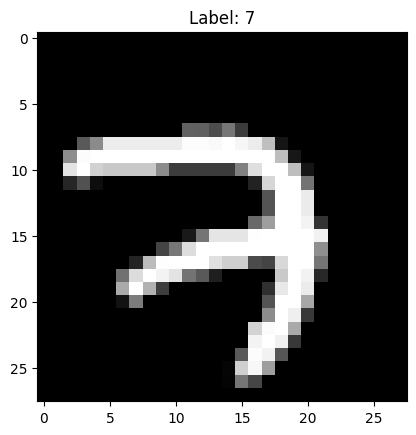

In [5]:
n = 5000
image, label = train_dataset.data[n], train_dataset.targets[n]

# 이미지 시각화
plt.imshow(image, cmap="gray")
plt.title(f"Label: {label}")
plt.show()

In [6]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size)

In [ ]:
train_loader

In [7]:
x_val, x_test = test_dataset.data[:5000], test_dataset.data[5000:]
y_val, y_test = test_dataset.targets[:5000], test_dataset.targets[5000:]

x_val.shape, y_val.shape

(torch.Size([5000, 28, 28]), torch.Size([5000]))

In [8]:
x_val = x_val / 255
x_test = x_test / 255

In [9]:
x_val = x_val.view(5000, 1, 28, 28)
x_test = x_test.view(5000, 1, 28, 28)
print(x_val.shape, x_test.shape)

torch.Size([5000, 1, 28, 28]) torch.Size([5000, 1, 28, 28])


In [ ]:
n_feature = 28 * 28
n_class = 10

model = nn.Sequential(nn.Flatten(), nn.Linear(n_feature, n_class)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)


In [11]:
epochs = 10
tr_loss_list, val_loss_list = [], []

for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss, _ = evaluate(x_val, y_val, model, loss_fn, device)
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch {t + 1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}")

Epoch 1, train loss : 0.525910, val loss : 0.381648
Epoch 2, train loss : 0.284543, val loss : 0.328463
Epoch 3, train loss : 0.244900, val loss : 0.296807
Epoch 4, train loss : 0.218440, val loss : 0.276627
Epoch 5, train loss : 0.199347, val loss : 0.262542
Epoch 6, train loss : 0.184564, val loss : 0.253453
Epoch 7, train loss : 0.173152, val loss : 0.247090
Epoch 8, train loss : 0.163859, val loss : 0.241718
Epoch 9, train loss : 0.156229, val loss : 0.237031
Epoch 10, train loss : 0.149847, val loss : 0.234174


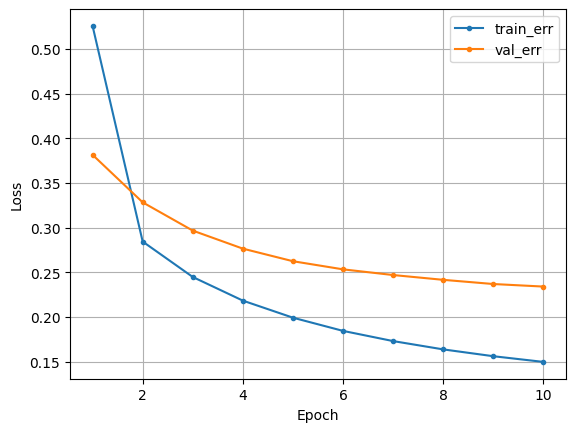

In [12]:
dl_learning_curve(tr_loss_list, val_loss_list)

In [18]:
_, pred = evaluate(x_test, y_test, model, loss_fn, device)

pred = nn.functional.softmax(pred, dim=1)
print(pred[:5])

tensor([[5.3205e-05, 2.5082e-05, 1.0285e-05, 9.3804e-01, 1.8234e-05, 6.1339e-02,
         6.8598e-07, 2.1991e-05, 3.7367e-04, 1.2058e-04],
        [3.4151e-05, 9.9155e-09, 9.5806e-04, 7.9731e-04, 4.9402e-02, 9.4180e-05,
         4.0808e-05, 3.7446e-04, 2.6656e-02, 9.2164e-01],
        [1.4001e-07, 1.7587e-12, 3.5009e-07, 3.1996e-06, 2.4858e-04, 1.3975e-07,
         8.1529e-10, 7.5255e-06, 8.6649e-05, 9.9965e-01],
        [2.9378e-09, 1.7775e-12, 4.6450e-09, 6.9983e-06, 3.2798e-10, 4.7183e-08,
         7.9938e-12, 1.7743e-12, 9.9998e-01, 9.4459e-06],
        [5.6726e-06, 1.2227e-13, 7.1441e-06, 2.4518e-08, 9.9947e-01, 7.9012e-05,
         1.0391e-05, 8.8220e-06, 8.1398e-06, 4.0955e-04]], device='cuda:0')


In [19]:
pred = np.argmax(pred.cpu().numpy(), axis=1)
print(pred[:5])

[3 9 9 8 4]


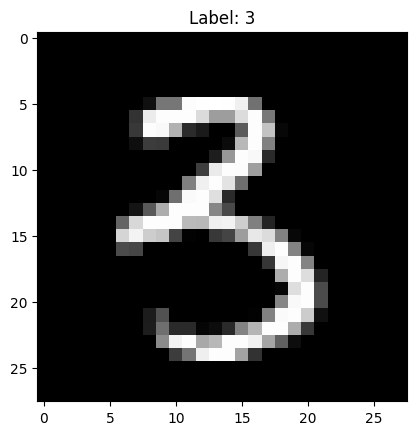

In [20]:
n = 0
image, label = test_dataset.data[5000 + n], test_dataset.targets[5000 + n]
plt.imshow(image, cmap="gray")
plt.title(f"Label: {label}")
plt.show()

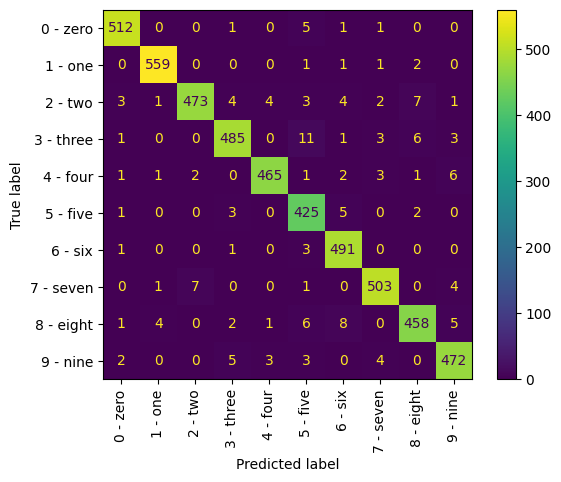

In [21]:
cm = confusion_matrix(y_test.cpu().numpy(), pred)
disp = ConfusionMatrixDisplay(cm, display_labels=train_dataset.classes)
disp.plot()
plt.xticks(rotation=90)
plt.show()

In [23]:
pred

array([3, 9, 9, ..., 4, 5, 6], shape=(5000,))

In [22]:
print(classification_report(y_test.cpu().numpy(), pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       520
           1       0.99      0.99      0.99       564
           2       0.98      0.94      0.96       502
           3       0.97      0.95      0.96       510
           4       0.98      0.96      0.97       482
           5       0.93      0.97      0.95       436
           6       0.96      0.99      0.97       496
           7       0.97      0.97      0.97       516
           8       0.96      0.94      0.95       485
           9       0.96      0.97      0.96       489

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



In [10]:
n_feature = 28 * 28
n_class = 10

model = nn.Sequential(
    nn.Flatten(), nn.Linear(n_feature, 20), nn.ReLU(), nn.Linear(20, n_class)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
